# SVM BTC

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="white")
#sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

import os
from os.path import dirname

%run BTC_training_SVM.ipynb

In [14]:
parent_dir = os.path.dirname(os.getcwd())
table=pd.read_csv(parent_dir + "/data/BTC ML Final.csv")
table.set_index('Date', inplace=True)
Y=table['UpDownSign']
X=table.drop(columns=['UpDownSign'])
#define total rolling period, roll over every 5 days
start=450
end=90
base= 5
n=round((start-end)/base) 
acc=np.zeros(n)
index=table['ChangePer'].index[-start:-end]
SVM=np.ones(n*base)
passive=np.ones(n*base)
for i in range (0,n):
    begin=-start+i*base
    end=-start+(i+1)*base
    clf=train_model(table.iloc[:begin,:])
    actual_return=X['ChangePer']/100
    if end==0:
        pred_signals=clf.predict(X.iloc[begin:,:])
        Y_test=Y.iloc[begin:]
        ret=actual_return.iloc[begin:]
    else:
        pred_signals=clf.predict(X.iloc[begin:end,:])
        Y_test=Y.iloc[begin:end]
        ret=actual_return.iloc[begin:end]
    acc[i]=accuracy_score(Y_test, pred_signals, normalize=True)*100.0
    #trading strategy:1 long;0 short
    #calculate trading strategy performance
    ret=ret.to_numpy()
    length=len(ret)
    signals=pred_signals
    value=np.zeros(length)
    investment=np.zeros(length)
    if i==0:
        value[0]=SVM[i*base]
        investment[0]=passive[i*base]
    else:
        value[0]=SVM[i*base-1]
        investment[0]=passive[i*base-1]
    for j in range(0,length-1):
        if signals[j]==1:
            value[j+1]=value[j]*(1+ret[j+1])
        else: 
            value[j+1]=value[j]*(1-ret[j+1])
        investment[j+1]=investment[j]*(1+ret[j+1])
    SVM[i*base:(i+1)*base]=value
    passive[i*base:(i+1)*base]=investment

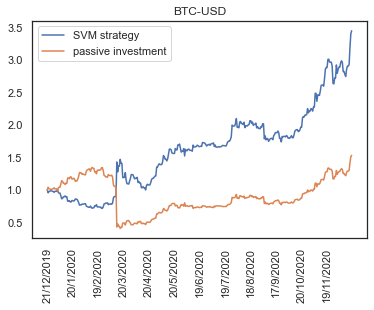

In [15]:
#plot figure
fig, ax=plt.subplots()
plt.plot(index, SVM, label='SVM strategy')
plt.plot(index, passive, label='passive investment')
plt.xticks(rotation=90)
plt.title("BTC-USD")
plt.legend()

every_nth = 30
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [16]:
# calculate trading strategy volatility and Sharpe ratio (annualised)
strategy_return=np.zeros(length)
for i in range(0,length-1):
    strategy_return[i]=SVM[i+1]/SVM[i]-1
std_strategy=strategy_return.std()*np.sqrt(length)
std_invest=ret.std()*np.sqrt(length)
ret_strategy=(SVM[-1]/SVM[0]-1)
ret_invest=(passive[-1]/passive[0]-1)
rf= 1.56/100 #1-y treasury yield
SR_strategy=(ret_strategy-rf)/std_strategy
SR_invest=(ret_invest-rf)/std_invest
print("Return: strategy ",ret_strategy, " investment ", ret_invest)
print("Standard deviation: strategy ",std_strategy, " investment ", std_invest)
print("Sharpe ratio: strategy ",SR_strategy, " investment ", SR_invest)

Return: strategy  2.448426327612601  investment  0.5328026930370158
Standard deviation: strategy  0.04806643701857564  investment  0.07620883839639513
Sharpe ratio: strategy  50.613826996838085  investment  6.786649736698792
